In [11]:
!pip install rapidfuzz textdistance catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
%matplotlib inline
import joblib
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from typing import List, Union
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

from nltk import everygrams
import re
import textdistance
from unicodedata import normalize, category

from catboost import CatBoostClassifier
import rapidfuzz
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (roc_curve,
                             roc_auc_score,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import (RandomizedSearchCV,
                                     StratifiedShuffleSplit,
                                     train_test_split)

In [3]:
all_documents = joblib.load("/content/drive/MyDrive/hack_2023_06/all_documents_v3.pkl")

# Extract "golden name" from file

In [8]:
CLOSINGS = [
  'материалы инженерных изысканий',
  'технический отч[ёе]т',
  'проектная документация',
  'отч[ёе]тная документация',
  'инженерные изыскания',
  'отч[ёе]тная техническая документация'
]

OPENINGS = [
  'государственный контракт',
  'технический отч[ёе]т',
  'научно-проектная документация',
  'размещение объекта'
]


closing_re = re.compile(r"([\S\s]+)((?<=\n\n)(?:{}))".format("|".join(CLOSINGS)), re.IGNORECASE)
opening_re = re.compile(r"((?<=\n\n)(?:{}))([\S\s]+)".format("|".join(OPENINGS)), re.IGNORECASE)
broken_hyphen_re = re.compile(r"(?<=[a-zа-я])- (?=[a-zа-я])")
paragraph_re = re.compile(r"\n\n(?![a-zа-я])")


def extract_main_name_candidate(m: str) -> str:
  try:
    m = closing_re.search(m).groups()[0]
    m = re.sub("(?:{})".format("|".join(CLOSINGS)), "", m, flags=re.IGNORECASE).strip()
    return opening_re.search(m).groups()[1]
  except Exception as e:
    return m.split("\n\n")[-1]


def broken_hyphen(text: str) -> str:
  return broken_hyphen_re.sub("", text)


def filter_matches(match_: str) -> Union[str, None]:
  match_ = paragraph_re.split(match_)[-1].strip()
  if len(match_) > 5:
    return broken_hyphen(match_)

In [9]:
main_names = {}

for document_group, documents in all_documents.items():
  main_names[document_group] = main_names.get(document_group, {})
  for document_name, parsed_content in tqdm(documents.items()):
    if type(parsed_content) != str:
      for page_num, content in parsed_content.items():
        if page_num < 2:
          res = extract_main_name_candidate(content["text"])
          if len(res) > 0:
            main_names[document_group][document_name] = filter_matches(res)
            break

100%|██████████| 36/36 [00:00<00:00, 82.75it/s]


In [10]:
main_names["doc1"]["doc_1_Раздел ПД №2_Том 2_51-ППО.00027-21_СКЭ-25982.pdf"]

'Капитальный ремонт автомобильной дороги Р-215 Астрахань - Кочубей - Кизляр - Махачкала, подъезд к г. Грозный на участке км 70+127 – км 85+267, Чеченская Республика'

# Extract candidates for classification

In [15]:
HYPHENS = {
    '-',  # \u002d Hyphen-minus
    '‐',  # \u2010 Hyphen
    '‑',  # \u2011 Non-breaking hyphen
    '⁃',  # \u2043 Hyphen bullet
    '‒',  # \u2012 figure dash
    '–',  # \u2013 en dash
    '—',  # \u2014 em dash
    '―',  # \u2015 horizontal bar
}

MINUSES = {
    '-',  # \u002d Hyphen-minus
    '−',  # \u2212 Minus
    '－',  # \uff0d Full-width Hyphen-minus
    '⁻',  # \u207b Superscript minus
}

PLUSES = {
    '+',  # \u002b Plus
    '＋',  # \uff0b Full-width Plus
    '⁺',  # \u207a Superscript plus
}

SLASHES = {
    '/',  # \u002f Solidus
    '⁄',  # \u2044 Fraction slash
    '∕',  # \u2215 Division slash
}


APOSTROPHES = {
    "'",  # \u0027
    '’',  # \u2019
    '՚',  # \u055a
    'Ꞌ',  # \ua78b
    'ꞌ',  # \ua78c
    '＇',  # \uff07
}

SINGLE_QUOTES = {
    "'",  # \u0027
    '‘',  # \u2018
    '’',  # \u2019
    '‚',  # \u201a
    '‛',  # \u201b

}

DOUBLE_QUOTES = {
    '"',  # \u0022
    '“',  # \u201c
    '”',  # \u201d
    '„',  # \u201e
    '‟',  # \u201f
    '«',
    '»'
}

ACCENTS = {
    '`',  # \u0060
    '´',  # \u00b4
}

PRIMES = {
    '′',  # \u2032
    '″',  # \u2033
    '‴',  # \u2034
    '‵',  # \u2035
    '‶',  # \u2036
    '‷',  # \u2037
    '⁗',  # \u2057
}

QUOTES = APOSTROPHES | SINGLE_QUOTES | DOUBLE_QUOTES | ACCENTS | PRIMES
DASHES = HYPHENS | MINUSES

In [16]:
# поправить пунктуацию
char2idx_1 = re.compile(r"й")
char2idx_2 = re.compile(r"ё")
idx2char_1 = re.compile(r"<p>99</p>")
idx2char_2 = re.compile(r"<p>98</p>")

trash_punct = re.compile(f"[(),№;<>%‰*•{''.join(QUOTES)}]+")
double_space = re.compile(r"\s+")


def remove_accents(text: str) -> str:
    text = char2idx_1.sub(idx2char_1.pattern, text)
    text = char2idx_2.sub(idx2char_2.pattern, text)
    text = "".join(c for c in normalize("NFD", text)
                   if category(c) != "Mn")
    text = idx2char_1.sub("й", text)
    text = idx2char_2.sub("ё", text)
    return text


def filter_short_paragraphs(text: str,
                            min_token_len: int = 2,
                            min_char_len: int = 10) -> str:
  paragraphs = text.split("\n\n")
  return "\n\n".join([i for i in paragraphs
                      if len(i) >= min_char_len
                        and len(i.split()) >= min_token_len])


def preprocess_text(text: str) -> str:
  text = broken_hyphen(filter_short_paragraphs(text))
  text = text.lower()
  text = remove_accents(text)

  for slash in SLASHES:
    text = text.replace(slash, "/")
  for dash in DASHES:
    text = text.replace(dash, "-")
  for plus in PLUSES:
    text = text.replace(plus, "+")

  text = trash_punct.sub(" ", text)
  text = double_space.sub(" ", text)
  return text.strip()

In [17]:
CANDIDATES_SIMILARITY = 50
candidates = []

for group_name, documents in tqdm(all_documents.items()):
  for document_name, parsed_content in documents.items():
    if type(parsed_content) != str and main_names[group_name].get(document_name):
      for page_num, context in parsed_content.items():
          processed_golden_name = preprocess_text(main_names[group_name][document_name])
          processed_annots = list(map(preprocess_text, context["annots"]))
          if len(processed_annots) > 0:
            if len(set(processed_golden_name.split()) & (set(processed_golden_name.split()))) < 2:
              break
          raw_candidates = [" ".join(ngram) for ngram in everygrams(preprocess_text(context["text"]).split(),
                                                                    min_len=int(len(processed_golden_name.split())/1.5),
                                                                    max_len=len(processed_golden_name.split())+5)]
          for candidate in raw_candidates:
              score = rapidfuzz.fuzz.QRatio(processed_golden_name, candidate)
              if score > CANDIDATES_SIMILARITY:
                  candidates.append(( group_name,
                                      document_name,
                                      page_num,
                                      candidate,
                                      int(candidate in processed_annots)))

100%|██████████| 3/3 [00:33<00:00, 11.04s/it]


In [18]:
df = pd.DataFrame(candidates, columns=["group_name", "doc_name", "page_num", "candidate", "label"])

df["targets"] = df \
  .progress_apply(lambda x: main_names[x["group_name"]].get(x["doc_name"]), axis=1) \
  .progress_apply(lambda x: preprocess_text(x) if x else None)

df.head(5)

100%|██████████| 85721/85721 [00:10<00:00, 8557.09it/s] 


,group_name,doc_name,page_num,candidate,label,targets
0,doc1,doc_1_Раздел ПД №2_Том 2_51-ППО.00027-21_СКЭ-2...,0,от 10 июля 2014 г. заказчик - фку управление ф...,0,капитальный ремонт автомобильной дороги р-215 ...
1,doc1,doc_1_Раздел ПД №2_Том 2_51-ППО.00027-21_СКЭ-2...,0,от 10 июля 2014 г. заказчик - фку управление ф...,0,капитальный ремонт автомобильной дороги р-215 ...
2,doc1,doc_1_Раздел ПД №2_Том 2_51-ППО.00027-21_СКЭ-2...,0,10 июля 2014 г. заказчик - фку управление феде...,0,капитальный ремонт автомобильной дороги р-215 ...
3,doc1,doc_1_Раздел ПД №2_Том 2_51-ППО.00027-21_СКЭ-2...,0,10 июля 2014 г. заказчик - фку управление феде...,0,капитальный ремонт автомобильной дороги р-215 ...
4,doc1,doc_1_Раздел ПД №2_Том 2_51-ППО.00027-21_СКЭ-2...,0,10 июля 2014 г. заказчик - фку управление феде...,0,капитальный ремонт автомобильной дороги р-215 ...


In [19]:
df.shape

(85721, 6)

In [20]:
df.groupby(["group_name"])["doc_name"].nunique()

group_name
doc1         13
doc2         10
ПД для ИИ     8
Name: doc_name, dtype: int64

# Generate features and sets for classifier

## Split dataset

In [21]:
df["label"].mean()

0.0013532273305257754

In [22]:
train = df[df.groupby(["doc_name"])["label"].transform("max") == 1] \
  .reset_index(drop=True)
test = df[df.groupby(["doc_name"])["label"].transform("max") == 0] \
  .reset_index(drop=True)

train.shape, test.shape

((69737, 6), (15984, 6))

In [23]:
train.groupby(["group_name"])["doc_name"].nunique()

group_name
doc1         11
doc2         10
ПД для ИИ     4
Name: doc_name, dtype: int64

In [24]:
test.groupby(["group_name"])["doc_name"].nunique()

group_name
doc1         2
ПД для ИИ    4
Name: doc_name, dtype: int64

In [25]:
train_docs = train[train["group_name"] != "ПД для ИИ"].groupby(["group_name"])["doc_name"].apply(lambda x: x.drop_duplicates().sample(8)) \
  .reset_index(level=-1, drop=True) \
  .reset_index()

In [26]:
valid = train.merge(train_docs, on=["group_name", "doc_name"], how="inner")
valid.shape

(35211, 6)

In [27]:
train_docs["exclude"] = 1
train = train.merge(train_docs, on=["group_name", "doc_name"], how="left")
train = train[train["exclude"] != 1] \
  .reset_index(drop=True) \
  .drop("exclude", axis=1)

del train_docs

train.shape

(34526, 6)

In [28]:
assert valid["label"].max() == 1

## Add augmentations

In [29]:
augmented = train.copy()

def generate_random_token_deletions(text: str, num_dels: int = 5) -> str:
  arr = text.split()
  try:
    for i in np.random.randint(low=0, high=len(arr)-1,
                               size=(np.random.randint(1, min(num_dels, int(len(arr)//1.5))),)):
      arr.pop(i)
  except Exception as e:
    pass
  return " ".join(arr)

augmented["candidate"] = augmented["candidate"] \
  .progress_apply(generate_random_token_deletions)

train = pd.concat([train, augmented], axis=0) \
  .reset_index(drop=True)

100%|██████████| 34526/34526 [00:00<00:00, 35123.57it/s]


In [30]:
augmented = train.copy()

def generate_random_char_deletions(text: str, num_dels: int = 5) -> str:
  try:
    for i in np.random.randint(low=0, high=len(text)-1,
                               size=(np.random.randint(1, min(num_dels, int(len(text)//1.5))),)):
      text = text[0:i] + text[i+1:]
  except Exception as e:
    pass
  return text

augmented["candidate"] = augmented["candidate"] \
  .progress_apply(generate_random_char_deletions)

train = pd.concat([train, augmented], axis=0) \
  .reset_index(drop=True)

del augmented

100%|██████████| 69052/69052 [00:02<00:00, 31725.11it/s]


In [31]:
letters = ''.join(set(''.join(train["candidate"])))
print(letters)

pчиъюцaвпщ9e0к6оnыге+øu.жэs5dтд8@ь:-xg/мiах4vуowбрлфйс2зшёt r13ня7


In [32]:
augmented = train.copy()

def generate_random_misspellings(text: str, word_prob: float = .1) -> str:
  try:
    new_arr = []
    for word in text.split():
      outcome = random.random()
      if outcome <= word_prob:
          ix = random.choice(range(len(word)))
          new_word = ''.join([word[w] if w != ix else random.choice(letters)
                              for w in range(len(word))])
          new_arr.append(new_word)
      else:
          new_arr.append(word)
  except:
    pass
  return " ".join(new_arr)


augmented["candidate"] = augmented["candidate"] \
  .progress_apply(generate_random_char_deletions)

train = pd.concat([train, augmented], axis=0) \
  .reset_index(drop=True)

del augmented

100%|██████████| 138104/138104 [00:03<00:00, 41376.77it/s]


In [33]:
train = train[train["candidate"] != ""] \
  .drop_duplicates() \
  .reset_index(drop=True)

valid = valid[valid["candidate"] != ""] \
  .drop_duplicates() \
  .reset_index(drop=True)

test = test[test["candidate"] != ""] \
  .drop_duplicates() \
  .reset_index(drop=True)

train.shape, valid.shape, test.shape

((275776, 6), (34823, 6), (15956, 6))

In [34]:
train["label"].mean(), valid["label"].mean(), test["label"].mean()

(0.0008666453933627292, 0.0018665824311518248, 0.0)

In [35]:
pred = pd.concat([train[train["candidate"] == train["targets"]],
                  valid[valid["candidate"] == valid["targets"]]], axis=0) \
  .reset_index(drop=True)

train = train[train["candidate"] != train["targets"]].reset_index(drop=True)
valid = valid[valid["candidate"] != valid["targets"]].reset_index(drop=True)

train["label"].mean(), valid["label"].mean(), test["label"].mean()

(0.0007906055748572921, 0.0003742622714840939, 0.0)

In [36]:
train = pd.concat([train[train["label"] == 1],
                   train[train["label"] == 0].groupby(["doc_name"]) \
                                             .apply(lambda x: x.sample(frac=.5, random_state=42))], axis=0) \
  .reset_index(drop=True)

In [37]:
assert (train["targets"].apply(len) == 0).sum() == 0
assert (valid["targets"].apply(len) == 0).sum() == 0
assert (test["targets"].apply(len) == 0).sum() == 0

## Generate features

In [38]:
digit_re = re.compile(r"[\d]+")


def matched_numbers(external_name: str, internal_name: str) -> float:
    external_numbers = set(digit_re.findall(external_name))
    internal_numbers = set(digit_re.findall(internal_name))
    union = external_numbers.union(internal_numbers)
    intersection = external_numbers.intersection(internal_numbers)
    if len(external_numbers) == 0 and len(internal_numbers) == 0:
        return 1.
    else:
        return len(intersection)/ len(union)


def generate_features(df: pd.DataFrame) -> pd.DataFrame:
    print("calculate editions")
    df["qratio"] = df \
      .apply(lambda x: rapidfuzz.fuzz.QRatio(x["candidate"],
                                             x["targets"]), axis=1) \
      .astype(float)
    df["partial_token_set_ratio"] = df \
      .apply(lambda x: rapidfuzz.fuzz.partial_token_set_ratio(x["candidate"],
                                                              x["targets"]), axis=1) \
      .astype(float)
    df["token_set_ratio"] = df.apply(lambda x: rapidfuzz.fuzz.token_set_ratio(x["candidate"],
                                                                              x["targets"]), axis=1) \
      .astype(float)

    print("calculate string sims")
    df["jaro_winkler"] = df \
      .apply(lambda x: textdistance.jaro_winkler(x["candidate"],
                                                 x["targets"]), axis=1) \
      .astype(float)
    df["levenshtein"] = df \
      .apply(lambda x: textdistance.levenshtein(x["candidate"],
                                                x["targets"]) / len(x["candidate"]), axis=1) \
      .astype(float)
    df["damerau_levenshtein"] = df \
      .apply(lambda x: textdistance.damerau_levenshtein(x["candidate"],
                                                        x["targets"]) / len(x["candidate"]), axis=1) \
      .astype(float)
    df["cosine"] = df \
      .apply(lambda x: textdistance.cosine(x["candidate"],
                                           x["targets"]), axis=1) \
      .astype(float)

    print("calculate union chars")
    df["chars_in_common"] = df \
      .apply(lambda x: len(set(x["candidate"]) & set(x["targets"])) / len(set(x["candidate"] + x["targets"])), axis=1) \
      .astype(float)
    df["matching_numbers"] = df \
      .apply(lambda x: matched_numbers(x["candidate"], x["targets"]), axis=1) \
      .astype(float)
    df["words_in_common"] = df \
      .apply(lambda x: len(set(x["candidate"].split()) & set(x["targets"].split())) / len(set(x["candidate"].split()+x["targets"].split())), axis=1) \
      .astype(float)
    df["target_in_candidate"] = df \
      .apply(lambda x: int(x["targets"] in x["candidate"]), axis=1) \
      .astype(int)
    df["candidate_in_targets"] = df \
      .apply(lambda x: int(x["candidate"] in x["targets"]), axis=1) \
      .astype(int)

    print("calculate candidates characteristics")
    df["candidate_contains_special_chars"] = df["candidate"] \
      .str.contains("[^\w\s]", regex=True) \
      .astype(int)

    print("calculate targets characteristics")
    df["target_contains_special_chars"] = df["targets"] \
      .str.contains("[^\w\s]", regex=True) \
      .astype(int)
    return df

In [39]:
%%time
train = generate_features(train.reset_index(drop=True))
valid = generate_features(valid.reset_index(drop=True))
test = generate_features(test.reset_index(drop=True))

calculate editions
calculate string sims
calculate union chars
calculate candidates characteristics
calculate targets characteristics
calculate editions
calculate string sims
calculate union chars
calculate candidates characteristics
calculate targets characteristics
calculate editions
calculate string sims
calculate union chars
calculate candidates characteristics
calculate targets characteristics
CPU times: user 1min 8s, sys: 300 ms, total: 1min 8s
Wall time: 1min 18s


In [40]:
train.shape, valid.shape, test.shape

((137977, 20), (34735, 20), (15956, 20))

In [41]:
train["label"].mean(), valid["label"].mean(), test["label"].mean()

(0.001579973473839843, 0.0003742622714840939, 0.0)

In [42]:
dropcols = ["group_name", "doc_name", "page_num", "candidate", "label", "targets"]
cat_cols = (train.drop(dropcols, axis=1).dtypes == int).astype(int) \
  .where(lambda x: x == 1) \
  .dropna() \
  .index.tolist()
print(cat_cols)

['target_in_candidate', 'candidate_in_targets', 'candidate_contains_special_chars', 'target_contains_special_chars']


In [43]:
train.sample(5).T

,91342,112460,37705,129338,12783
group_name,ПД для ИИ,ПД для ИИ,doc1,ПД для ИИ,ПД для ИИ
doc_name,Отчет ИИ №3_Книга №3_(ДПТПиИТ-2020-834-ИЭИ3)_Т...,Отчет ИИ №3_Книга №3_(ДПТПиИТ-2020-834-ИЭИ3)_Т...,doc_1_Раздел ПД №10_Том 10.2.1_51-.00027-21_СК...,Отчет ИИ №3_Книга №3_(ДПТПиИТ-2020-834-ИЭИ3)_Т...,3864 ИИ 4 К. Изм. 2.02608-19_ГГЭ-07898.pdf
page_num,60,2,140,13,0
candidate,1 0 001 1 из табл. 8.1.8.10 видно что исследов...,. подъездная автомобильная дорога от 1-го успе...,автомобилной дороги р-215 астрахань - кочубей ...,объекту автомобильная дорога 1 беларусь - от м...,от москвы через рязань пензу самару уфу до чел...
label,0,0,0,0,0
targets,автомобильная дорога м - 1 беларусь - от москв...,автомобильная дорога м - 1 беларусь - от москв...,капитальный ремонт автомобильной дороги р-215 ...,автомобильная дорога м - 1 беларусь - от москв...,строительство и реконструкция автомобильной до...
qratio,59.310345,77.067669,77.099237,54.749745,74.387528
partial_token_set_ratio,100.0,100.0,100.0,100.0,100.0
token_set_ratio,76.857749,99.305556,92.81768,79.417879,88.163265
jaro_winkler,0.749251,0.789954,0.71406,0.73868,0.71237


## Parameters selection

In [45]:
%%time

params = {
    "max_depth": [5, 8, 10],
    "learning_rate": [0.05, 0.1, 0.5],
    "n_estimators": np.arange(50, 500, 50),
    "l2_leaf_reg": np.arange(1.0, 5.0, 0.5),
    "min_child_samples": [4, 8, 16]
}

class_weight = np.sqrt((train["label"] == 0).sum()/(train["label"] == 1).sum())

cv = StratifiedShuffleSplit(n_splits=3, random_state=42)
clf = CatBoostClassifier(random_seed=42,
                         verbose=0,
                         cat_features=cat_cols,
                         scale_pos_weight=class_weight)
search = RandomizedSearchCV(estimator=clf,
                            n_iter=10,
                            param_distributions=params,
                            cv=cv,
                            scoring="f1_macro")
search.fit(train.drop(dropcols, axis=1), train["label"], verbose=0)

print(" Results from Random Search " )
print("\n The best estimator across searched params:\n", search.best_estimator_)
print("\n The best score across searched params:\n", search.best_score_)
print("\n The best parameters across searched params:\n", search.best_params_)

 Results from Random Search 

 The best estimator across searched params:

 The best score across searched params:
 0.7514847499353975

 The best parameters across searched params:
 {'n_estimators': 250, 'min_child_samples': 4, 'max_depth': 10, 'learning_rate': 0.05, 'l2_leaf_reg': 3.5}
CPU times: user 7min 37s, sys: 13.6 s, total: 7min 50s
Wall time: 6min 3s


## Model training

In [140]:
model = CatBoostClassifier(random_seed=42,
                           verbose=1,
                           cat_features=cat_cols,
                           **search.best_params_)
model.fit(train.drop(dropcols, axis=1),
          train["label"])

0:	learn: 0.5212072	total: 56.4ms	remaining: 14s
1:	learn: 0.3919498	total: 113ms	remaining: 14s
2:	learn: 0.2965697	total: 171ms	remaining: 14.1s
3:	learn: 0.2192500	total: 228ms	remaining: 14s
4:	learn: 0.1633774	total: 283ms	remaining: 13.9s
5:	learn: 0.1241565	total: 344ms	remaining: 14s
6:	learn: 0.0960898	total: 399ms	remaining: 13.9s
7:	learn: 0.0706352	total: 438ms	remaining: 13.3s
8:	learn: 0.0541140	total: 505ms	remaining: 13.5s
9:	learn: 0.0422491	total: 571ms	remaining: 13.7s
10:	learn: 0.0337172	total: 633ms	remaining: 13.7s
11:	learn: 0.0269671	total: 688ms	remaining: 13.7s
12:	learn: 0.0221776	total: 747ms	remaining: 13.6s
13:	learn: 0.0185178	total: 809ms	remaining: 13.6s
14:	learn: 0.0155874	total: 864ms	remaining: 13.5s
15:	learn: 0.0134632	total: 920ms	remaining: 13.5s
16:	learn: 0.0118960	total: 986ms	remaining: 13.5s
17:	learn: 0.0106060	total: 1.04s	remaining: 13.4s
18:	learn: 0.0096865	total: 1.09s	remaining: 13.3s
19:	learn: 0.0089216	total: 1.15s	remaining: 13.

In [141]:
model_final = CatBoostClassifier(random_seed=42,
                                 verbose=1,
                                 cat_features=cat_cols,
                                 **search.best_params_)
model_final.fit(pd.concat([train.drop(dropcols, axis=1), valid.drop(dropcols, axis=1)], axis=0),
                pd.concat([train["label"], valid["label"]], axis=0))

0:	learn: 0.5184184	total: 117ms	remaining: 29.1s
1:	learn: 0.3942613	total: 237ms	remaining: 29.4s
2:	learn: 0.2856264	total: 364ms	remaining: 30s
3:	learn: 0.2151476	total: 536ms	remaining: 32.9s
4:	learn: 0.1619127	total: 750ms	remaining: 36.8s
5:	learn: 0.1239369	total: 918ms	remaining: 37.3s
6:	learn: 0.0964952	total: 1.09s	remaining: 38s
7:	learn: 0.0757825	total: 1.23s	remaining: 37.3s
8:	learn: 0.0569609	total: 1.42s	remaining: 38.1s
9:	learn: 0.0447744	total: 1.59s	remaining: 38.2s
10:	learn: 0.0347053	total: 1.73s	remaining: 37.6s
11:	learn: 0.0270294	total: 1.9s	remaining: 37.6s
12:	learn: 0.0216242	total: 2.04s	remaining: 37.2s
13:	learn: 0.0177971	total: 2.22s	remaining: 37.5s
14:	learn: 0.0148858	total: 2.41s	remaining: 37.8s
15:	learn: 0.0127882	total: 2.57s	remaining: 37.6s
16:	learn: 0.0111602	total: 2.71s	remaining: 37.1s
17:	learn: 0.0099370	total: 2.87s	remaining: 37s
18:	learn: 0.0089990	total: 2.99s	remaining: 36.4s
19:	learn: 0.0081934	total: 3.15s	remaining: 36.

# Analyze results

In [142]:
train_scores = model.predict_proba(train.drop(dropcols, axis=1))
valid_scores = model.predict_proba(valid.drop(dropcols, axis=1))

In [143]:
# наверное стоило откалибровать модель

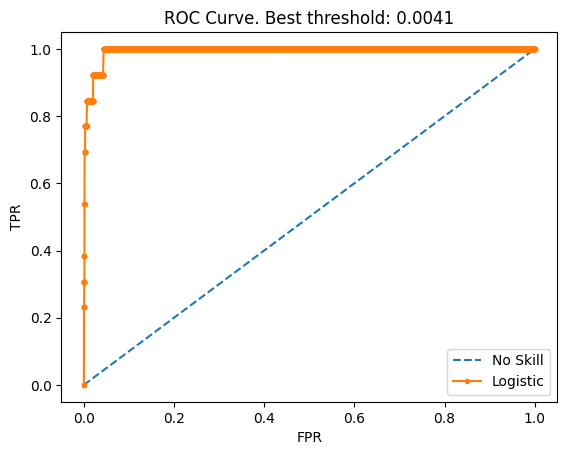

In [144]:
fpr, tpr, thresholds = roc_curve(valid["label"], valid_scores[:, 1])

gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
best_thresh = thresholds[ix]

plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill")
plt.plot(fpr, tpr, marker=".", label="Logistic")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve. Best threshold: %.4f" % best_thresh)
plt.legend()
plt.show()

In [145]:
joblib.dump({"classifier": model_final, "threshold": best_thresh}, "/content/classifier.pkl")

['/content/classifier.pkl']

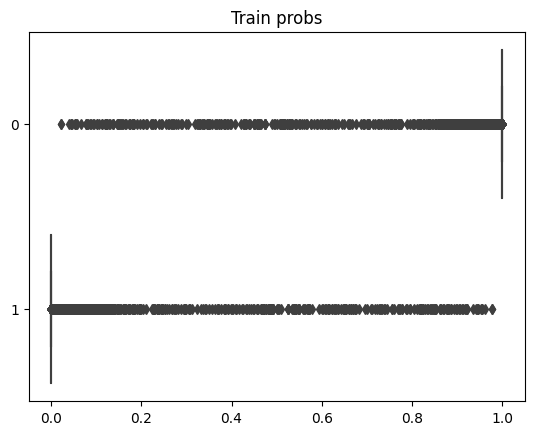

In [146]:
sns.boxplot(train_scores, orient="h")
plt.title("Train probs")
plt.show()

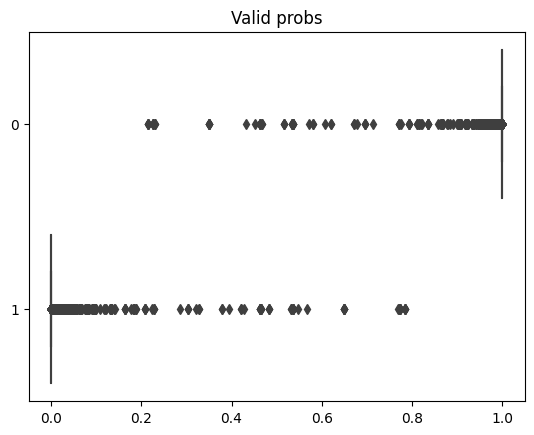

In [147]:
sns.boxplot(valid_scores, orient="h")
plt.title("Valid probs")
plt.show()

In [148]:
train_preds = model.predict(train.drop(dropcols, axis=1))
valid_preds = model.predict(valid.drop(dropcols, axis=1))

test_scores = model.predict_proba(test.drop(dropcols, axis=1))
test_preds = model.predict(test.drop(dropcols, axis=1))

In [149]:
print("TRAIN results")
print("AUC-ROC score: %.3f" % roc_auc_score(train["label"], train_scores[:, 1]))
print("Metrics over model predicts")
print(classification_report(train["label"], train_preds))
print("Metrics over model scores with threshold")
print(classification_report(train["label"], (train_scores[:, 1] > best_thresh).astype(int)))
print("\n\n")
print("VALID results")
print("AUC-ROC score: %.3f" % roc_auc_score(valid["label"], valid_scores[:, 1]))
print("Metrics over model predicts")
print(classification_report(valid["label"], valid_preds))
print("Metrics over model scores with threshold")
print(classification_report(valid["label"], (valid_scores[:, 1] > best_thresh).astype(int)))
print("TEST results")
print(f"Number of positive matches: {test_preds.sum()}")
print(f"Number of positive matches after threshold: {(valid_scores[:, 1] > best_thresh).sum()}")

TRAIN results
AUC-ROC score: 1.000
Metrics over model predicts
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    137759
           1       0.95      0.64      0.76       218

    accuracy                           1.00    137977
   macro avg       0.98      0.82      0.88    137977
weighted avg       1.00      1.00      1.00    137977

Metrics over model scores with threshold
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    137759
           1       0.08      1.00      0.15       218

    accuracy                           0.98    137977
   macro avg       0.54      0.99      0.57    137977
weighted avg       1.00      0.98      0.99    137977




VALID results
AUC-ROC score: 0.994
Metrics over model predicts
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34722
           1       0.12      0.23      0.16        13

    accuracy

In [150]:
r = 0
for _, row in test[test_preds == 1].sample(frac=1.).iterrows():
  if r == 10:
    break
  print(f"candidate (file: {row['doc_name']}, p: {row['page_num']}): {row['candidate']}\nfor targets: {row['targets']}")
  print("\n")
  r += 1

candidate (file: Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf, p: 23): харабалинского и ахтубинского района астраханской области
for targets: харабалинского и ахтубинского районов астраханской области


candidate (file: Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf, p: 5): харабалинского и ахтубинского района астраханской области
for targets: харабалинского и ахтубинского районов астраханской области


candidate (file: Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf, p: 38): харабалинского и ахтубинского районов астраханской области в
for targets: харабалинского и ахтубинского районов астраханской области


candidate (file: Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf, p: 30): харабалинского ахтубинского районов астраханской области
for targets: харабалинского и ахтубинского районов астраханской области


candidate (file: Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf, p: 57): харабалинского и ахтубинского районов астраханской области не
for targets: харабалинского и ахтубинского районов астраханской области


candi

In [151]:
print("FALSE POSITIVES")
r = 0
for _, row in valid[(valid_preds == 1) & (valid["label"] == 0)].sample(frac=1.).iterrows():
  if r == 10:
    break
  print(f"candidate (file: {row['doc_name']}, p: {row['page_num']}): {row['candidate']}\nfor targets: {row['targets']}")
  print("\n")
  r += 1

FALSE POSITIVES
candidate (file: doc_2_Том 5.00001-21_ЕГЭ-26404.pdf, p: 11): строительства и обустройства скважин куста 10 гарюшкинского месторождения
for targets: строительство и обустройство скважин куста 10 гарюшкинского месторождения


candidate (file: doc_2_Раздел ПД №1 Часть №2 Изм.1.00001-21_ЕГЭ-26404.pdf, p: 69): строительство и обустройство скважин куста 10 гарюшкинского месторождения л д
for targets: строительство и обустройство скважин куста 10 гарюшкинского месторождения


candidate (file: doc_2_Раздел ПД №1 Часть №2 Изм.1.00001-21_ЕГЭ-26404.pdf, p: 47): строительство и обустройство скважин куста 10 гарюшкинского месторождения л д
for targets: строительство и обустройство скважин куста 10 гарюшкинского месторождения


candidate (file: doc_2_Раздел ПД №1 Часть №2 Изм.1.00001-21_ЕГЭ-26404.pdf, p: 51): строительство и обустройство скважин куста 10 гарюшкинского месторождения л д
for targets: строительство и обустройство скважин куста 10 гарюшкинского месторождения


candidate 

In [152]:
print("FALSE NEGATIVES")
r = 0
for _, row in valid[(valid_preds == 0) & (valid["label"] == 1)].sample(frac=1.).iterrows():
  if r == 10:
    break
  print(f"candidate (file: {row['doc_name']}, p: {row['page_num']}): {row['candidate']}\nfor targets: {row['targets']}")
  print("\n")
  r += 1

FALSE NEGATIVES
candidate (file: doc_1_Раздел ПД №10_Том 10.4_51-10.00027-21_СКЭ-25982.pdf, p: 4): капитальный ремонт автомобильной дороги р-215 астрахань-кочубей-кизляр-махачкала подъезд к г. грозный на участке км 70+127 - км 85+267 чеченская республика
for targets: капитальный ремонт автомобильной дороги р-215 астрахань - кочубей - кизляр - махачкала подъезд к г. грозный на участке км 70+127 - км 85+267 чеченская республика


candidate (file: doc_1_Раздел ПД №3_Том 3.3_51-ТКР..00027-21_СКЭ-25982.pdf, p: 5): капитальный ремонт автомобильной дороги р-215 астрахань - кочубей - кизляр - махачкала подъезд к г. грозный на участке км 70+127 - км 85+267 чеченская республика.
for targets: капитальный ремонт автомобильной дороги р-215 астрахань - кочубей - кизляр - махачкала подъезд к г. грозный на участке км 70+127 - км 85+267 чеченская республика


candidate (file: doc_2_Раздел ПД №1 Часть №2 Изм.1.00001-21_ЕГЭ-26404.pdf, p: 8): строительство и обустройство скважин куста 10 гарюшкинского мес

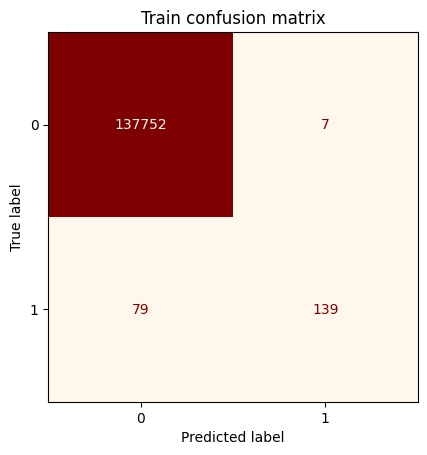

In [153]:
cm = confusion_matrix(train["label"], train_preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap="OrRd", colorbar=False)
plt.title("Train confusion matrix")
plt.show()

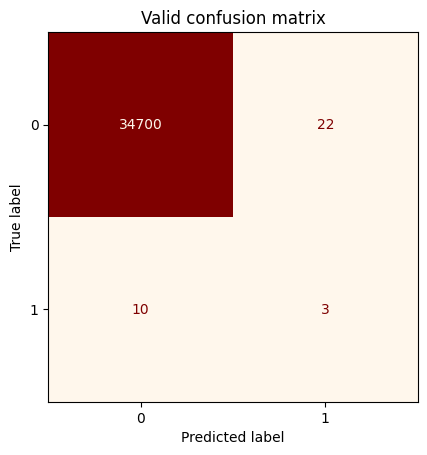

In [154]:
cm = confusion_matrix(valid["label"], valid_preds)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap="OrRd", colorbar=False)
plt.title("Valid confusion matrix")
plt.show()

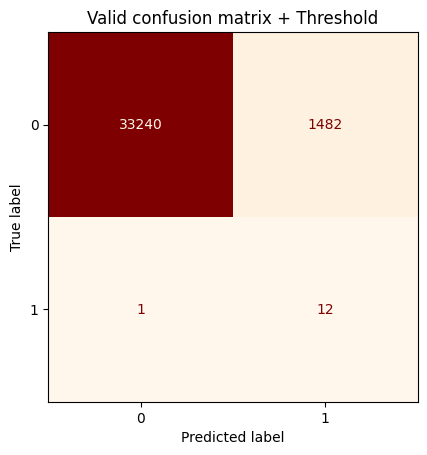

In [155]:
cm = confusion_matrix(valid["label"], (valid_scores[:, 1] > best_thresh).astype(int))
cmd = ConfusionMatrixDisplay(cm)
cmd.plot(cmap="OrRd", colorbar=False)
plt.title("Valid confusion matrix + Threshold")
plt.show()

# DEMO

In [156]:
doc = "Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf"

In [157]:
res = all_documents["ПД для ИИ"][doc]
len(res)

219

In [158]:
base_name = preprocess_text(
"""«Газопровод-отвод «Харабали – Ахтубинск 2 - Ахтубинск 1»

Харабалинского и Ахтубинского районов

Астраханской области»"""
)

In [159]:
candidates = []
for page_num, context in tqdm(res.items()):
  raw_candidates = [" ".join(ngram) for ngram in everygrams(preprocess_text(context["text"]).split(),
                                                            min_len=int(len(base_name.split())/1.5),
                                                            max_len=len(base_name.split())+5)]
  for candidate in raw_candidates:
      score = rapidfuzz.fuzz.QRatio(base_name, candidate)
      if score > CANDIDATES_SIMILARITY:
          candidates.append(( "ПД для ИИ",
                              doc,
                              page_num,
                              candidate,
                              None ))

len(candidates)

100%|██████████| 219/219 [00:00<00:00, 411.03it/s]


3594

In [160]:
demo_df = pd.DataFrame(candidates, columns=["group_name", "doc_name", "page_num", "candidate", "label"])
demo_df["targets"] = base_name

In [161]:
demo_df = generate_features(demo_df)

calculate editions
calculate string sims
calculate union chars
calculate candidates characteristics
calculate targets characteristics


In [163]:
demo_preds = model_final.predict(demo_df.drop(dropcols, axis=1))
demo_scores = model_final.predict_proba(demo_df.drop(dropcols, axis=1))

In [164]:
r = 0
for _, row in demo_df[demo_scores[:, 1] > best_thresh].sample(frac=1.).iterrows():
  if r == 10:
    break
  print(f"candidate (file: {row['doc_name']}, p: {row['page_num']}): {row['candidate']}\nfor targets: {row['targets']}")
  print("\n")
  r += 1

candidate (file: Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf, p: 33): газопровода-отвода харабали-ахтубинск-2-ахтубинск-1 харабалинского и ахтубинского районов астраханской области расположена в прикаспийской низменности на левобережной пойменной
for targets: газопровод-отвод харабали - ахтубинск 2 - ахтубинск 1 харабалинского и ахтубинского районов астраханской области


candidate (file: Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf, p: 9): газопровод-отвод - ахтубинск харабалинского и ахтубинского районов астраханской области
for targets: газопровод-отвод харабали - ахтубинск 2 - ахтубинск 1 харабалинского и ахтубинского районов астраханской области


candidate (file: Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf, p: 130): газопровод- отвод харабали - ахтубинск 2 - ахтубинск 1 харабалинского
for targets: газопровод-отвод харабали - ахтубинск 2 - ахтубинск 1 харабалинского и ахтубинского районов астраханской области


candidate (file: Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf, p: 0): газопровод-отвод х

In [165]:
demo_df["score"] = demo_scores[:, 1]
demo_df["page_num"] = demo_df["page_num"] + 1

demo_df.loc[demo_df["targets"] == demo_df["candidate"], "score"] = 1.

demo_df = demo_df[demo_df["score"] > best_thresh] \
  .sort_values(["score"], ascending=False)
demo_df = demo_df.groupby(["doc_name", "page_num", "targets"]) \
  .agg({"candidate": "first",
        "score": max}) \
  .reset_index() \
  .sort_values(["page_num"]) \
  .rename(columns={"doc_name": "Наименование файла",
                   "page_num": "Номер страницы",
                   "targets": "Распознанное наименование объекта",
                   "candidate": "Совпадения по тексту документа",
                   "score": "Уверенность в совпадении"})

In [166]:
demo_df

,Наименование файла,Номер страницы,Распознанное наименование объекта,Совпадения по тексту документа,Уверенность в совпадении
0,Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf,1,газопровод-отвод харабали - ахтубинск 2 - ахту...,газопровод-отвод харабали - ахтубинск 2 - ахту...,1.000000
1,Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf,2,газопровод-отвод харабали - ахтубинск 2 - ахту...,газопровод-отвод харабали - ахтубинск 2 - ахту...,1.000000
2,Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf,3,газопровод-отвод харабали - ахтубинск 2 - ахту...,газопровод-отвод харабали - ахтубинск 2 - ахту...,1.000000
3,Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf,6,газопровод-отвод харабали - ахтубинск 2 - ахту...,газопровод-отвод харабали - ахтубинск 2 - ахту...,0.245762
4,Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf,9,газопровод-отвод харабали - ахтубинск 2 - ахту...,газопровод-отвод харабали - ахтубинск-2 - ахту...,0.135679
5,Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf,10,газопровод-отвод харабали - ахтубинск 2 - ахту...,газопровод-отвод - ахтубинск харабалинского и ...,0.012152
6,Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf,13,газопровод-отвод харабали - ахтубинск 2 - ахту...,газопровол-отвод харабали-ахтубинск 2 - ахтуби...,0.350947
7,Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf,24,газопровод-отвод харабали - ахтубинск 2 - ахту...,газопровод-отвод харабали - ахтубинск 2 - ахту...,0.403216
8,Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf,26,газопровод-отвод харабали - ахтубинск 2 - ахту...,газопровод-отвод харабали - ахтубинск 2 - ахту...,0.245762
9,Раздел ИИ ИЭИ4.1.06920-22_ГГЭ-35136.pdf,31,газопровод-отвод харабали - ахтубинск 2 - ахту...,газопровода-отвода харабали - ахтубинск-2 - ах...,0.512824
